# Improving Models
## Boosting, Random Forests, ADA Boost, Gradient Boost
#### Math 3480 - Machine Learning - Dr. Michael E. Olson

## Reading
* Geron, Chapter 7

### Additional Resources
* [YouTube StatQuest: Random Forests](https://www.youtube.com/watch?v=J4Wdy0Wc_xQ&t=214s)
* [YouTube StatQuest: ADABoost](https://www.youtube.com/watch?v=LsK-xG1cLYA&t=211s)

Decision Trees are efficient, but often have poor results. To improve the results, we aggregate the information, or look at groups of predictors. This group of predictors is called an __ensemble__.

### Voting
One way we can get the best results is to run the data through the different methods (Logistic Regression, SVM, Random Forests, KNN,...) and take the model that performs the best
* Run the data through each ML algorithm
* Aggregate (or collect) the data together
* Take a majority vote on which method has the most correct classifications, and aggregate the results

The majority-vote classifier is called *hard voting*.

*Soft voting* would be predicting the class with the highest class probability averaged over all the individual classifiers.

### Bagging (Bootstrap AGGregatING)
To bootstrap (or create a subset of your dataset):
* Take a random element from your data, and include it in your dataset
  * with replacement (it's not removed from the original dataset, so it could be selected again later)
* Continue to take a determined number of elements from your dataset, with replacement
  * If you repeat some elements, that is just fine - it is useful in the algorithm
  * How many elements in each bag?
    * If $n$ is the number of elements in the original dataset, and $n'$ is the number in the bag, we want $n'<n$
    * A good round figure would be $n' \approx 60\% \cdot n$. Not a hard number - can vary based on need

We will then use each bag to be trained into models. We then apply our data to each model and take the average for our result. This is the __ensemble__ process. 

### Out-of-Bag Evaluation
In bagging, we created a bootstrapped dataset allowing duplicate entries in each bag. This means that, on average, roughly 63% of the data is used to make bags. The remaining 37% are *out-of-bag instances*.

__Out-of-Bag Evaluation__ takes the 37% of data that wasn't used and runs them through the tree the bag created.
* If the results of the tree are the same as the data's results, then it was successful
* If the results of the tree are different, then 

You can find how well the out-of-bag instances performed in the tree by setting `oob_score=True` in your model, then printing `oob_score_`.

#### How to do Bagging in Python

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 6)
from sklearn import datasets

iris_data = datasets.load_iris()
iris = pd.DataFrame(iris_data['data'], columns=iris_data['feature_names'])
species = pd.DataFrame(iris_data['target'], columns=['species_num'])

def test_species(x):
    if x==0: return "setosa"
    if x==1: return "versicolor"
    if x==2: return "virginica"

iris['species'] = species['species_num'].apply(lambda x: test_species(x))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris.drop(['species'],axis=1), iris['species'], test_size=0.3, random_state=32)

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# n_estimators :    Number of models to make
# max_samples :     Number of instances in each bag
# bootstrap :       If True, bootstraps with replacement. If False, without replacement
# n_jobs :          Number of processors to use (-1 means use all processors)
# oob_score :       Calculate Out-of-Bag Evaluation
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, max_samples=100, 
    bootstrap=True, n_jobs=-1, oob_score=True)
    
bag_clf.fit(X_train, y_train)
print(" OOB Score = ",bag_clf.oob_score_)
y_predict = bag_clf.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test,y_predict))
from sklearn.metrics import accuracy_score
print(" Accuracy Score = ", accuracy_score(y_test,y_predict))

### Random Forests
The idea of Random Forests is to create a number of decision trees, and test your data with all trees.
* Round 1:
  * Bootstrap your data
  * Using the bootstrapped data, select only a few variables to test
  * Determine which variable creates the best split in the data - this is your first node
  * Select only a few of the remaining variables to test next
  * The variable that creates the best split becomes the second node
  * ...etc...
* Round 2:
  * Repeat the same steps
  * The result will be a second tree
* Round 3:
  * Repeat again
* ...
* Do this for however many rounds we want (generally 100's of times)

The result of this process is a large number of Decision Tree models, which we call a *Random Forest*.

How does it work? We run new data down each Decision Tree. We count the results, and the result that is most common is our classification (Voting method).

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 6)
from sklearn import datasets

iris_data = datasets.load_iris()
iris = pd.DataFrame(iris_data['data'], columns=iris_data['feature_names'])
species = pd.DataFrame(iris_data['target'], columns=['species_num'])

def test_species(x):
    if x==0: return "setosa"
    if x==1: return "versicolor"
    if x==2: return "virginica"

iris['species'] = species['species_num'].apply(lambda x: test_species(x))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris.drop(['species'],axis=1), iris['species'], test_size=0.3, random_state=32)

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200)
   # n_estimators = number of trees
rfc.fit(X_train,y_train)
rfc_predict = rfc.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test,rfc_predict))

Another method for improving our models is to evaluate the results, then add a little more weight to the incorrectly labelled data. There are a number of processes to do this. We're focusing on two: __AdaBoost__ and __Gradient Boost__.

### AdaBoost
With AdaBoost, we start with a decision tree that has only one node (and two leaves).
* A tree with only one node and two leaves is called a __stump__.
* Note that since a decision is made with only one variable, a stump is a *weak learner*.
* But this doesn't matter. We will take the weak learners and make them stronger.

We make a stump for each variable. We run through the different stumps and classify all the data, and give each instance a weight.
1. In the first round, each of the *m* instances has the same weight *1/m*
  * Run the data through the first stump (separate by the first variable)
  * Track the number of correct and incorrect classifications using the Gini index
  * Do the same for all stumps
  * Use these results to create a new weight
    * Calculate the total error $r_j$
    * Calculate the Predictor Weight $\alpha_j$
    * Calculate and normalize the new weight $w^{(i)}$

>$$r_j = \frac{\sum_{i=1; \hat{y}_j^{(i)}\ne y^{(i)}}^m w^{(i)}}{\sum_{i=1}^m w^{(i)}}$$
>$$\alpha_j = \eta \log\frac{1-r_j}{r_j}$$
>$$w^{(i)} \leftarrow \begin{cases}
w^{(i)} & \text{if }\hat{y}_j^{(i)} = y^{(i)}\\
w^{(i)}e^{\alpha_j} & \text{if }\hat{y}_j^{(i)}\ne y^{(i)}
\end{cases} $$
>* $\hat{y}_j^{(i)}$ is the predition for the j-th predictor for the i-th instance
>* $\eta$ is the learning rate hyperparameter

This is what the Predictor Weight $\alpha_j$ looks like:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(0,1,0.01)
y = np.log((1-x)/x)
plt.plot(x,y)
plt.title('Predictor Weight')
plt.xlabel('Total Error')

* If the total error is very small, then the predictor weight is laregely positive (guesses the correct answer)
* If the total error is very large, then the predictor weight is laregely negative (guesses the incorrect answer)
* If the total error is in the middle, then the predictor weight is about 0 (no better than random guessing)

We then repeat these steps with the updated weights. We keep repeating this process until either the desired number of predictors is reached, or when a perfect predictor is found.

Let's run through an example with ten data instances ${x_0,...,x_9}$ and six variables ${y_0,...,y_5}$.
1. Weights for all instances = $1/10 = 0.1$

In [ ]:
import numpy as np
n = 10
w = np.ones(n)/n
w

2. Run the data for all six variables. We find the Gini index is best for $y_3$.
    * Creating a stump for $y_3$ produces two errors: $x_5$ and $x_8$ were incorrectly classified

In [ ]:
error = np.ones(10)
error[5] = -1
error[8] = -1
error

3. Calculate the total error
    * $r_1 = \frac{2}{10}=0.2$
4. Calculate the Predictor Weight $\alpha_1$
    * For now, let's set a learning rate of 1/2
    * $\alpha_1 = 0.5\log\frac{1-0.2}{0.2} = 0.693$

In [ ]:
r = sum(-0.5*(error-1))/n
print("r = ",r)

a = 0.5*np.log( (1 - r) / r )
print("a = ",a)

5. Find the new weights

In [ ]:
w = w*np.exp(-error*a)
w

6. Normalize the new weights

In [ ]:
w = w/sum(w)
w

You run this through the decision trees to get the next stump using either
* the Weighted Gini Index, or 
* create a new dataset the same size as the original, repeating the heavily weighted instances
  * Create a Total Gathered Weight $gw_k = \sum_{i=0}^k w_i$ for each element $k$.
  * Choose a random number between 0 and 1
  * If that number falls in the range $(gw_{k-1},gw_k)$, then the $k$th element is put into the dataset
    * Because the misclassified instance has a high weight, it will likely be chosen multiple times
  * For the new dataset, give each instance the same weight $1/m$
    * Since the misclassified instances may appear multiple times, then it's weight will essentially be $1/m$ multiplied by the number of times it appears in the new dataset

Run the steps again.

In [ ]:
n = 8
w = np.ones(n)/n

error = np.ones(n)
error[3] = -1
#error[8] = -1

r = sum(-0.5*(error-1))/n
print("r = ",r)
a = 0.5*np.log( (1 - r) / r )
print("a = ",a)

w = w*np.exp(-error*a)
w/sum(w)

To determine the classification for new data, run it through each stump. Add the $\alpha_j$ values for all stumps that came out in one category, and add all $\alpha_j$ values for the other category. The category with the higher sum wins, and is the classification for that data.
$$\hat{y}(x) = \argmax_k \sum_{j=1; \hat{y}_j(x)=k}^N \alpha_j$$
where $N$ is the number of predictors.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 6)
from sklearn import datasets

iris_data = datasets.load_iris()
iris = pd.DataFrame(iris_data['data'], columns=iris_data['feature_names'])
species = pd.DataFrame(iris_data['target'], columns=['species_num'])

def test_species(x):
    if x==0: return "setosa"
    if x==1: return "versicolor"
    if x==2: return "virginica"

iris['species'] = species['species_num'].apply(lambda x: test_species(x))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris.drop(['species'],axis=1), iris['species'], test_size=0.3, random_state=32)


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)

y_precidt = ada_clf.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test,rfc_predict))

#### Gradient Boosting
Another way to improve model performance is using __Gradient Boosting__. Gradient boosting is applied to both Regression and Classification models. First, let's look at regression models:

This method is very similar to AdaBoost, but instead of changing weights every time, it looks at the residual errors made by the previous predictor. Here's how it works:
1. Make an initial prediction for all data (generally, the average of the observed values)
2. Find the residuals (actual - predicted)
3. Classify all these residuals in a decision tree
    * Generally, we create a tree with anywhere between 4 and 32 leaves
    * If we have multiple values in a given leaf, then average all values in that leaf
4. Add the initial prediction in (1) to the classification in the decision tree in (3)
    * *Note*: Doing this will actually overfit the data and creates high variance in predictions
    * To prevent this, we scale this prediction (multiply it by a number between 0 and 1). This is where the gradient descent happens
5. Repeat steps 2-4 using the new predictions and new residuals
6. Continue repeating steps 2-4 until we reach a maximum number of trees or until additional trees stop improving the model


##### Math for the Gradient Boosting
__Input__: 
* Data $\{(x_i,y_i)\}_{i=1}^n$
* Differentiable __Loss Function__ $L(y_i,F(x))$
  * Often, we take,
  $$L(y_i,F(x)) = \frac{1}{2}(Observed-Predicted)^2$$
__Step 1__:
* Initialize model with a constant value:
$$F_0(x)=\argmin_\gamma \sum_{i=1}^n L(y,\gamma)$$
* $\gamma$ is just the predicted value
* We can find the $\argmin$ by taking the derivative of the loss function and setting it equal to 0 to minimize the errors
$$\frac{dL}{d Predicted} = -(Observed-Predicted)=0$$
__Step 2__:
```python
for m=1 to M:
```
1. Compute residuals $r_{im} = -\left[\frac{\partial L}{\partial F}\right]_{F(x)=F_{m-1}(x)}$ for $i={1\dots,n}$. 
    * This is just the residual $(Observed-Predicted)$
    * In practice, $M=100$, but can vary
2. Fit a regression tree to the $r_{im}$ values and create terminal region $R_{jm}$ for $j=1\dots J_m$.
    * This is the value for each leaf in the decision tree
3. For $j=1\dots J_m$, compute $\gamma_{jm} = \argmin_\gamma \sum_{x_i\in R_{ij}} L(y_i,F_{m-1}(x_i)+\gamma)$
    * This produces the average of the residuals in each leaf
4. Update $F_m(x) = F_{m-1}(x) + \nu \sum_{j=1}^{J_m} \gamma_{jm}I(x\in R_{jm})$
    * This is the new prediction
    * $\nu$ is the learning rate
__Step 3__:
* Output $F_M(x)$

Then, this model is used with any new data.


First, run the model. Make a prediction, then calculate the residuals.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

### First prediction can be done as an average
y0 = np.mean(y_train)*np.ones_like(y_train)
### or using a decision tree
#tree_reg1 = DecisionTreeRegressor(max_depth=2)
#y0 = tree_reg1.fit(X_train, y_train)

r0 = y - y0 # Residuals from first esimate

Then, train and fit a new model to the residuals.

In [ ]:
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X_train, r0)

y1 = tree_reg1.predict(X_train) 
r1 = y - y1 # Residuals from first tree

Keep going!

In [ ]:
tree_reg2= DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X_train, r1)

y2 = tree_reg2.predict(X_train)
r2 = y - y2 # Residuals from third tree

You can keep going as far as is necessary.

The prediction will then be the sum of the predictions in each tree.

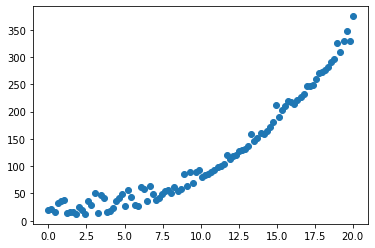

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

X = np.linspace(0,20,100)
y = X**2 - 4*X + 15.3 + 40**np.random.random(len(X))

plt.scatter(X,y)

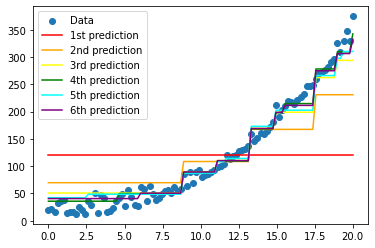

In [7]:
plt.scatter(X,y,label="Data")

L_rate = 1.0
L_rate = 0.6

# Initial Prediction
y0 = np.mean(y)*np.ones_like(y)
y_predict = y0
plt.plot(X,y0,color="red",label="1st prediction")

# 1st Tree
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X.reshape(-1,1), y-y0)

y1 = tree_reg1.predict(X.reshape(-1,1))
y_predict += L_rate*y1
plt.plot(X,y_predict,color="orange", label="2nd prediction")

# 2nd Tree
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X.reshape(-1,1), y-y_predict)

y2 = tree_reg2.predict(X.reshape(-1,1))
y_predict += L_rate*y2
plt.plot(X,y_predict,color="yellow", label="3rd prediction")

# 3rd Tree
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X.reshape(-1,1), y-y_predict)

y3 = tree_reg3.predict(X.reshape(-1,1))
y_predict = y0 + L_rate*y3
plt.plot(X,y_predict,color="green", label="4th prediction")

# # 4th Tree
tree_reg4 = DecisionTreeRegressor(max_depth=2)
tree_reg4.fit(X.reshape(-1,1), y-y_predict)

y4 = tree_reg4.predict(X.reshape(-1,1))
y_predict = y0 + L_rate*y4
plt.plot(X,y_predict,color="cyan", label="5th prediction")

# 5th Tree
tree_reg5 = DecisionTreeRegressor(max_depth=2)
tree_reg5.fit(X.reshape(-1,1), y-y_predict)

y5 = tree_reg5.predict(X.reshape(-1,1))
y_predict = y0 + L_rate*y5
plt.plot(X,y_predict,color="purple", label="6th prediction")

plt.legend()

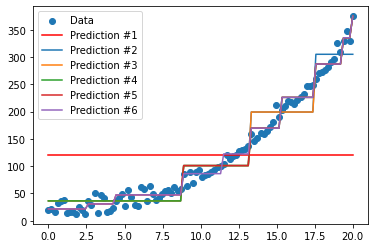

In [8]:
plt.scatter(X,y,label="Data")

L_rate = 1.0
#L_rate = 0.6

# Initial Prediction
y0 = np.mean(y)*np.ones_like(y)
y_predict = y0
plt.plot(X,y0,color="red",label="Prediction #1")

# Trees
tree1 = DecisionTreeRegressor(max_depth=2)
tree2 = DecisionTreeRegressor(max_depth=2)
tree3 = DecisionTreeRegressor(max_depth=2)
tree4 = DecisionTreeRegressor(max_depth=2)
tree5 = DecisionTreeRegressor(max_depth=2)

n = 2
for i in [tree1, tree2, tree3, tree4, tree5]:
    i.fit(X.reshape(-1,1), y-y0)
    yi = i.predict(X.reshape(-1,1))
    y_predict += L_rate*yi
    plt.plot(X,y_predict,label="Prediction #{0}".format(n))
    n += 1
    
plt.legend()

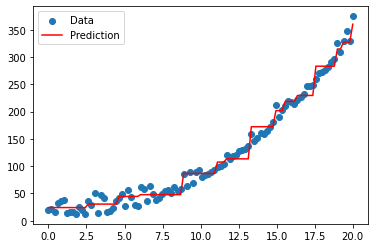

In [11]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(max_depth=2, n_estimators=5, learning_rate=0.6)
gbr.fit(X.reshape(-1,1),y)
y_predict = gbr.predict(X.reshape(-1,1))

plt.scatter(X,y,label="Data")
plt.plot(X,y_predict,label="Prediction",color='red')
plt.legend()